# Bi-Directional Generative Adversarial Networks (BiGANs / ALI)


---

## 1. Overview & Definition

A **Bi-Directional GAN (BiGAN)** learns both a generator and an encoder:

- Generator $G(z)$ maps latent $z$ to data $x$.
- Encoder $E(x)$ maps data $x$ back to latent $z$.

Let:

- $z \sim p(z)$ be the prior (e.g., $ \mathcal{N}(0,I) $).
- $x \sim p_{\text{data}}(x)$ be the data distribution.
- $G: \mathcal{Z} \rightarrow \mathcal{X}$.
- $E: \mathcal{X} \rightarrow \mathcal{Z}$.

The discriminator $D(x,z)$ receives joint pairs:

- Real pair: $(x, E(x))$.
- Fake pair: $(G(z), z)$.

---

## 2. Minimax Objective (BiGAN)

The adversarial objective optimized is:

$ \min_{G,E} \max_{D} \; \mathbb{E}_{x\sim p_{\text{data}}(x)}[\log D(x, E(x))] \;+\; \mathbb{E}_{z\sim p(z)}[\log(1 - D(G(z), z))] $

Intuition:

- $D$ learns to distinguish joint pairs from $p_{\text{data}}(x) \cdot \{E(x)\}$ versus $p(z)\cdot\{G(z)\}$.
- $G$ and $E$ are trained to make the two joint distributions indistinguishable.

---

## 3. Joint-distribution Perspective (Derivation sketch)

Define the two joint densities:

- Real joint: $p_{\text{real}}(x,z) = p_{\text{data}}(x)\,\delta(z = E(x))$  
- Fake joint: $p_{\text{fake}}(x,z) = p(z)\,\delta(x = G(z))$

For fixed $G,E$, the optimal discriminator (pointwise) is:

$ D^*(x,z) = \dfrac{p_{\text{real}}(x,z)}{p_{\text{real}}(x,z) + p_{\text{fake}}(x,z)} $

Substituting $D^*$ into the minimax objective yields minimization of the Jensen–Shannon divergence between the two joint distributions:

$ \min_{G,E} 2\cdot \text{JS}\big(p_{\text{real}}(x,z)\;||\;p_{\text{fake}}(x,z)\big) $

Thus BiGAN forces the joint $(x,z)$ distribution from real data+encoder to match the joint from prior+generator.

---

## 4. Key Insight

BiGAN provides an **inference mechanism** $E(x)$ so that:

$ E(x) \approx G^{-1}(x) $ (in practice approximate/injective)

This allows mapping both ways:

- Sampling: $z \sim p(z)$, $x = G(z)$.
- Inference / representation: $x \mapsto z = E(x)$.

---

## 5. Minimal PyTorch Implementation (toy / illustrative)

The following is a compact BiGAN training scaffold. It is intentionally minimal — use it as a starting point and adapt architectures, optimizers, and hyperparameters for real tasks.



In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
# ----------------------------
# Configuration
# ----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 128
latent_dim = 50
epochs = 100
lr = 2e-4

In [ ]:
# ----------------------------
# Dataset (MNIST)
# ----------------------------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1)),
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


In [ ]:
# ----------------------------
# Generator
# ----------------------------
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh()
        )

    def forward(self, z):
        return self.net(z)


In [ ]:
# ----------------------------
# Encoder
# ----------------------------
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(784, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, latent_dim)
        )

    def forward(self, x):
        return self.net(x)


In [ ]:
# ----------------------------
# Discriminator (Joint: x, z)
# ----------------------------
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(784 + latent_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 1)  # No sigmoid! BCEWithLogitsLoss handles that
        )

    def forward(self, x, z):
        xz = torch.cat([x, z], dim=1)
        return self.net(xz)


In [ ]:
# ----------------------------
# Initialize models
# ----------------------------
G = Generator().to(device)
E = Encoder().to(device)
D = Discriminator().to(device)

In [ ]:
# ----------------------------
# Optimizers and Loss
# ----------------------------
bce_loss = nn.BCEWithLogitsLoss()
optimizer_D = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_GE = optim.Adam(list(G.parameters()) + list(E.parameters()), lr=lr, betas=(0.5, 0.999))


In [ ]:
k = 3 #
p= 1
import os
from torchvision.utils import save_image

os.makedirs("bigan", exist_ok=True)


In [ ]:
# ----------------------------
# Training Loop
# ----------------------------
for epoch in range(1, epochs + 1):
    for i, (x_real, _) in enumerate(train_loader):
        x_real = x_real.to(device)
        batch_size = x_real.size(0)

        # Sample z from prior
        z_real = torch.randn(batch_size, latent_dim, device=device)

        # ----------------------
        # 1. Train Discriminator
        # ----------------------
        for _ in range(p):
          G.eval()
          E.eval()
          D.train()

          x_fake = G(z_real).detach()
          z_fake = E(x_real).detach()

          D_real = D(x_real, z_fake)
          D_fake = D(x_fake, z_real)

          label_real = torch.ones_like(D_real)
          label_fake = torch.zeros_like(D_fake)

          loss_D = bce_loss(D_real, label_real) + bce_loss(D_fake, label_fake)

          optimizer_D.zero_grad()
          loss_D.backward()
          optimizer_D.step()

        # --------------------------
        # 2. Train Generator + Encoder
        # --------------------------
        for _ in range(k):
          G.train()
          E.train()
          D.eval()

          x_fake = G(z_real)
          z_fake = E(x_real)

          D_real = D(x_real, z_fake)
          D_fake = D(x_fake, z_real)

          loss_GE = bce_loss(D_real, label_fake) + bce_loss(D_fake, label_real)

          optimizer_GE.zero_grad()
          loss_GE.backward()
          optimizer_GE.step()

        if i % 100 == 0:
            print(f"Epoch [{epoch}/{epochs}] Batch {i}/{len(train_loader)}",
                  f"Loss D: {loss_D.item():.4f}, Loss GE: {loss_GE.item():.4f}")

        # Save samples every epoch
        G.eval()
        with torch.no_grad():
            z = torch.randn(64, latent_dim, device=device)
            samples = G(z)
            samples = samples * 0.5 + 0.5  # Denormalize
            save_image(samples, f"bigan/epoch_{epoch}.png", nrow=8)
        G.train()


Epoch [1/100] Batch 0/469 Loss D: 1.4395, Loss GE: 1.2557
Epoch [1/100] Batch 100/469 Loss D: 0.6626, Loss GE: 0.2887
Epoch [1/100] Batch 200/469 Loss D: 2.2047, Loss GE: 1.7128
Epoch [1/100] Batch 300/469 Loss D: 0.4861, Loss GE: 0.0016
Epoch [1/100] Batch 400/469 Loss D: 0.1576, Loss GE: 0.1237
Epoch [2/100] Batch 0/469 Loss D: 0.1500, Loss GE: 0.1480
Epoch [2/100] Batch 100/469 Loss D: 0.1297, Loss GE: 0.6504
Epoch [2/100] Batch 200/469 Loss D: 0.2372, Loss GE: 0.6947
Epoch [2/100] Batch 300/469 Loss D: 0.1745, Loss GE: 3.7407
Epoch [2/100] Batch 400/469 Loss D: 0.0519, Loss GE: 4.0225
Epoch [3/100] Batch 0/469 Loss D: 0.1392, Loss GE: 9.8163
Epoch [3/100] Batch 100/469 Loss D: 0.0799, Loss GE: 10.9823
Epoch [3/100] Batch 200/469 Loss D: 0.0359, Loss GE: 9.1630
Epoch [3/100] Batch 300/469 Loss D: 0.0464, Loss GE: 12.4599
Epoch [3/100] Batch 400/469 Loss D: 0.1293, Loss GE: 8.7312
Epoch [4/100] Batch 0/469 Loss D: 0.0406, Loss GE: 2.2297
Epoch [4/100] Batch 100/469 Loss D: 0.0247, Lo

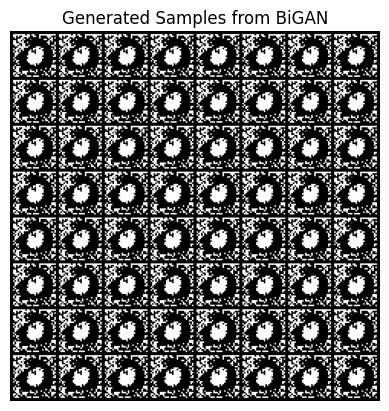

In [ ]:
# ----------------------------
# Generate Samples for Visualization
# ----------------------------
def show_samples():
    G.eval()
    with torch.no_grad():
        z = torch.randn(64, latent_dim, device=device)
        x_gen = G(z).view(-1, 1, 28, 28).cpu()
        grid = torchvision.utils.make_grid(x_gen, nrow=8)
        plt.imshow(grid.permute(1, 2, 0).squeeze())
        plt.axis('off')
        plt.title("Generated Samples from BiGAN")
        plt.show()

show_samples()